In [3]:
import socket
import struct
import numpy as np
import pandas as pd

In [ ]:


fraud = pd.read_csv("../data/raw/Fraud_Data.csv")

print("Shape:", fraud.shape)
print("\nInfo:")
print(fraud.info())
print("\nMissing Values:")
print(fraud.isna().sum())
print("\nDuplicate Rows:", fraud.duplicated().sum())

print("\nFraud Class Distribution:")
print(fraud['class'].value_counts())
print("\nFraud Class Percentage:")
print((fraud['class'].value_counts(normalize=True) * 100).round(2))


Shape: (151112, 11)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB
None

Missing Values:
user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0

In [2]:
# Convert signup_time and purchase_time to datetime
fraud['signup_time'] = pd.to_datetime(fraud['signup_time'])
fraud['purchase_time'] = pd.to_datetime(fraud['purchase_time'])

# Convert ip_address to string (important for the IP → integer step later)
fraud['ip_address'] = fraud['ip_address'].astype(str)

# Create time_since_signup (in hours)
fraud['time_since_signup'] = (fraud['purchase_time'] - fraud['signup_time']).dt.total_seconds() / 3600

# Extract features
fraud['hour_of_day'] = fraud['purchase_time'].dt.hour
fraud['day_of_week'] = fraud['purchase_time'].dt.dayofweek

fraud[['signup_time','purchase_time','time_since_signup','hour_of_day','day_of_week']].head()


,signup_time,purchase_time,time_since_signup,hour_of_day,day_of_week
0,2015-02-24 22:55:49,2015-04-18 02:47:11,1251.856111,2,5
1,2015-06-07 20:39:50,2015-06-08 01:38:54,4.984444,1,0
2,2015-01-01 18:52:44,2015-01-01 18:52:45,0.000278,18,3
3,2015-04-28 21:13:25,2015-05-04 13:54:50,136.690278,13,0
4,2015-07-21 07:09:52,2015-09-09 18:40:53,1211.516944,18,2


In [6]:
# Convert numeric IPs directly (drop decimals, then cast)
fraud['ip_int'] = fraud['ip_address'].astype(float).astype('uint32')

# For the mapping dataset, first convert to float and then uint32
ip_map['lower_int'] = ip_map['lower_bound_ip_address'].astype(float).astype('uint32')
ip_map['upper_int'] = ip_map['upper_bound_ip_address'].astype(float).astype('uint32')

print("NaNs in fraud['ip_int']:", fraud['ip_int'].isna().sum())
print("NaNs in IP map:", ip_map['lower_int'].isna().sum(), ip_map['upper_int'].isna().sum())

fraud[['ip_address','ip_int']].head()


NaNs in fraud['ip_int']: 0
NaNs in IP map: 0 0


,ip_address,ip_int
0,732758368.79972,732758368
1,350311387.865908,350311387
2,2621473820.11095,2621473820
3,3840542443.91396,3840542443
4,415583117.452712,415583117


In [10]:
fraud.columns, ip_map.columns


(Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
        'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class',
        'time_since_signup', 'hour_of_day', 'day_of_week', 'ip_int',
        'country_x', 'lower_int', 'upper_int', 'country_y', 'country'],
       dtype='object'),
 Index(['lower_bound_ip_address', 'upper_bound_ip_address', 'country',
        'lower_int', 'upper_int'],
       dtype='object'))

In [11]:
# Drop helper and duplicate columns
cols_to_drop = ['country_x', 'country_y', 'lower_int', 'upper_int']
fraud = fraud.drop(columns=[c for c in cols_to_drop if c in fraud.columns])

# Check final columns
print(fraud.columns)


Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class',
       'time_since_signup', 'hour_of_day', 'day_of_week', 'ip_int', 'country'],
      dtype='object')


In [12]:
# Count fraud by country
fraud.groupby('country')['class'].value_counts(normalize=True).unstack().fillna(0).sort_values(1, ascending=False).head(10)


class,0,1
country,,
Unknown,0.906354,0.093646


In [14]:
# Convert to numeric (coerce invalid values to NaN)
fraud['ip_address'] = pd.to_numeric(fraud['ip_address'], errors='coerce')

# Check conversion
fraud['ip_address'].head()
fraud['ip_address'].dtype


dtype('float64')

In [15]:
fraud['ip_int'] = fraud['ip_address'].round(0).astype('Int64')

# Check first few rows
fraud[['ip_address','ip_int']].head()


,ip_address,ip_int
0,52093.496895,52093
1,93447.138961,93447
2,105818.501505,105819
3,117566.664867,117567
4,131423.789042,131424


In [16]:
cols_to_drop = ['country','country_x','country_y','lower_int','upper_int']
fraud = fraud.drop(columns=[c for c in cols_to_drop if c in fraud.columns])


In [18]:
# Convert fraud IP ints to int64
fraud['ip_int'] = fraud['ip_int'].astype('int64')

# Convert IP mapping bounds to int64
ip_map['lower_int'] = ip_map['lower_int'].astype('int64')
ip_map['upper_int'] = ip_map['upper_int'].astype('int64')


In [19]:
# Sort both dataframes by the key
fraud = fraud.sort_values('ip_int')
ip_map_sorted = ip_map.sort_values('lower_int')

# Merge asof
fraud = pd.merge_asof(
    fraud,
    ip_map_sorted[['lower_int','upper_int','country']],
    left_on='ip_int',
    right_on='lower_int',
    direction='backward'
)

# Assign 'Unknown' if IP not within range
fraud['country'] = fraud.apply(
    lambda row: row['country'] if row['ip_int'] >= row['lower_int'] and row['ip_int'] <= row['upper_int'] else 'Unknown',
    axis=1
)

# Drop helper columns
fraud = fraud.drop(columns=['lower_int','upper_int'], errors='ignore')


In [20]:
fraud['country'].value_counts().head(10)

country
United States        58049
Unknown              21966
China                12038
Japan                 7306
United Kingdom        4490
Korea Republic of     4162
Germany               3646
France                3161
Canada                2975
Brazil                2961
Name: count, dtype: int64

In [21]:
# Total transactions and frauds per country
country_summary = fraud.groupby('country')['class'].agg(['count','sum'])
country_summary = country_summary.rename(columns={'count':'total_transactions','sum':'fraud_transactions'})

# Calculate fraud rate per country
country_summary['fraud_rate'] = country_summary['fraud_transactions'] / country_summary['total_transactions']

# Sort by fraud rate
country_summary = country_summary.sort_values('fraud_rate', ascending=False)

country_summary.head(10)


,total_transactions,fraud_transactions,fraud_rate
country,,,
Turkmenistan,1,1,1.000000
Namibia,23,10,0.434783
Sri Lanka,31,13,0.419355
Luxembourg,72,28,0.388889
Virgin Islands (U.S.),3,1,0.333333
Ecuador,106,28,0.264151
Tunisia,118,31,0.262712
Peru,119,31,0.260504
Bolivia,53,13,0.245283


C:\Users\THINKPAD\AppData\Local\Temp\ipykernel_18228\4049552485.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='fraud_rate', y='country', data=top_countries, palette='Reds_r')


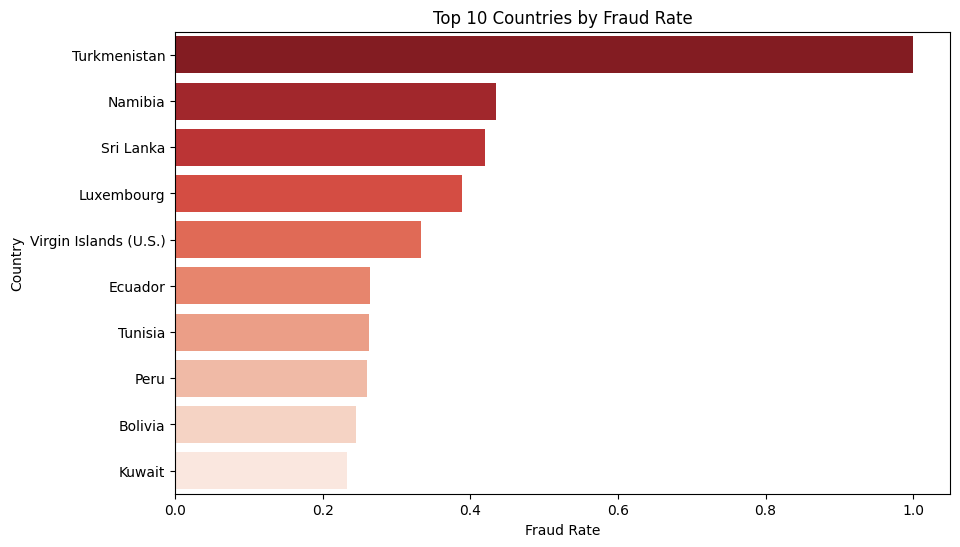

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Top 10 countries by fraud rate
top_countries = country_summary.head(10).reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x='fraud_rate', y='country', data=top_countries, palette='Reds_r')
plt.title("Top 10 Countries by Fraud Rate")
plt.xlabel("Fraud Rate")
plt.ylabel("Country")
plt.show()


In [23]:
# Numerical columns
num_cols = ['purchase_value','age','time_since_signup','hour_of_day','day_of_week','user_transaction_count']

# Categorical columns
cat_cols = ['device_id','source','browser','sex','country']


In [25]:
# Target
y = fraud['class']

# Features: drop columns we won’t use for modeling
X = fraud.drop(columns=[
    'class',
    'signup_time',
    'purchase_time',
    'ip_address',   # original IP
    'ip_int'        # integer IP
])

# Check first rows
X.head()


,user_id,purchase_value,device_id,source,browser,sex,age,time_since_signup,hour_of_day,day_of_week,country
0,62421,46,ZCLZTAJPCRAQX,Direct,Safari,M,36,489.726111,10,6,Unknown
1,173212,33,YFGYOALADBHLT,Ads,IE,F,30,301.339722,17,4,Unknown
2,242286,33,QZNVQTUITFTHH,Direct,FireFox,F,32,208.144444,8,1,Unknown
3,370003,33,PIBUQMBIELMMG,Ads,IE,M,40,2065.176111,21,3,Unknown
4,119824,55,WFIIFCPIOGMHT,Ads,Safari,M,38,391.005278,7,6,Unknown


### Encode Categorical column 

In [26]:
from sklearn.preprocessing import LabelEncoder

# Categorical columns
cat_cols = ['device_id','source','browser','sex','country']

# Make a copy for encoding
X_final = X.copy()

# Dictionary to store encoders
label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    X_final[col] = le.fit_transform(X_final[col].astype(str))
    label_encoders[col] = le

# Preview
X_final.head()


,user_id,purchase_value,device_id,source,browser,sex,age,time_since_signup,hour_of_day,day_of_week,country
0,62421,46,133226,1,4,1,36,489.726111,10,6,172
1,173212,33,128507,0,2,0,30,301.339722,17,4,172
2,242286,33,89991,1,1,0,32,208.144444,8,1,172
3,370003,33,81075,0,2,1,40,2065.176111,21,3,172
4,119824,55,117801,0,4,1,38,391.005278,7,6,172


### Scale Numerical Columns

In [27]:
from sklearn.preprocessing import StandardScaler

# Numerical columns
num_cols = ['user_id', 'purchase_value', 'age', 'time_since_signup', 'hour_of_day', 'day_of_week']

# Initialize scaler
scaler = StandardScaler()

# Apply scaling
X_final[num_cols] = scaler.fit_transform(X_final[num_cols])

# Preview
X_final.head()


,user_id,purchase_value,device_id,source,browser,sex,age,time_since_signup,hour_of_day,day_of_week,country
0,-1.193996,0.494721,133226,1,4,1,0.331793,-1.013679,-0.220124,1.489476,172
1,-0.233677,-0.214781,128507,0,2,0,-0.364448,-1.230613,0.792542,0.492565,172
2,0.365046,-0.214781,89991,1,1,0,-0.132367,-1.337931,-0.509456,-1.002803,172
3,1.472077,-0.214781,81075,0,2,1,0.795954,0.800513,1.371208,-0.005891,172
4,-0.696436,0.985915,117801,0,4,1,0.563874,-1.127359,-0.654123,1.489476,172


In [28]:
from sklearn.model_selection import train_test_split

# Target variable
y = fraud['class']

# Train-test split (stratified to preserve class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X_final,
    y,
    test_size=0.2,       # 80% train, 20% test
    random_state=42,     # reproducibility
    stratify=y           # maintain fraud/non-fraud ratio
)

# Check shapes
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train distribution:\n", y_train.value_counts(normalize=True))
print("y_test distribution:\n", y_test.value_counts(normalize=True))


X_train: (120889, 11)
X_test: (30223, 11)
y_train distribution:
 class
0    0.906352
1    0.093648
Name: proportion, dtype: float64
y_test distribution:
 class
0    0.906363
1    0.093637
Name: proportion, dtype: float64


In [29]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to training data
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Check new class distribution
import pandas as pd
pd.DataFrame({
    "Count": y_train_res.value_counts(),
    "Percentage (%)": y_train_res.value_counts(normalize=True) * 100
})


,Count,Percentage (%)
class,,
0,109568,50.0
1,109568,50.0


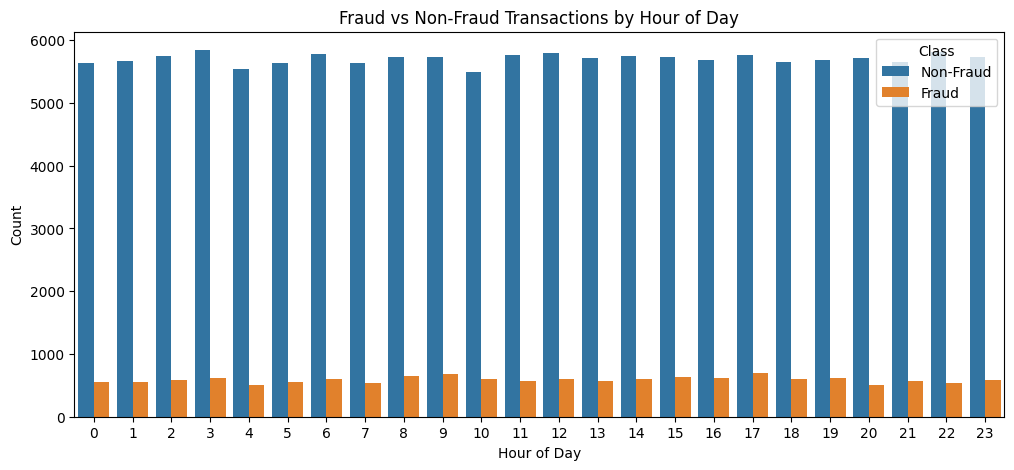

In [30]:
plt.figure(figsize=(12,5))
sns.countplot(x='hour_of_day', hue='class', data=fraud)
plt.title("Fraud vs Non-Fraud Transactions by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Count")
plt.legend(title="Class", labels=["Non-Fraud", "Fraud"])
plt.show()


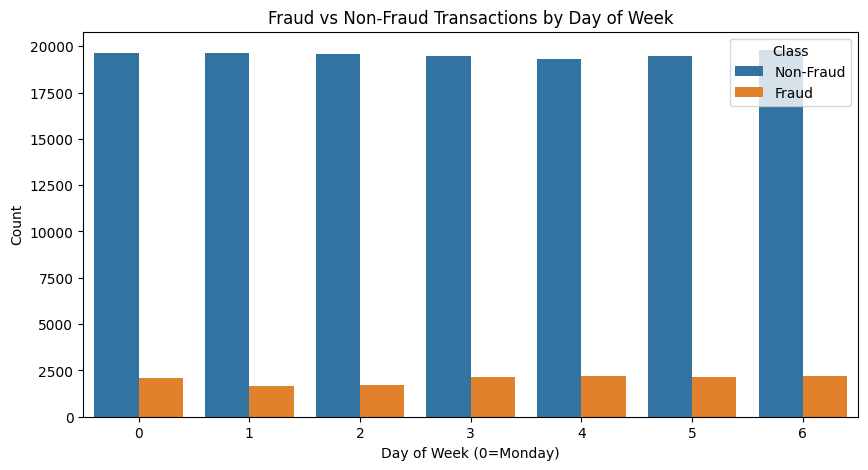

In [31]:
plt.figure(figsize=(10,5))
sns.countplot(x='day_of_week', hue='class', data=fraud)
plt.title("Fraud vs Non-Fraud Transactions by Day of Week")
plt.xlabel("Day of Week (0=Monday)")
plt.ylabel("Count")
plt.legend(title="Class", labels=["Non-Fraud", "Fraud"])
plt.show()


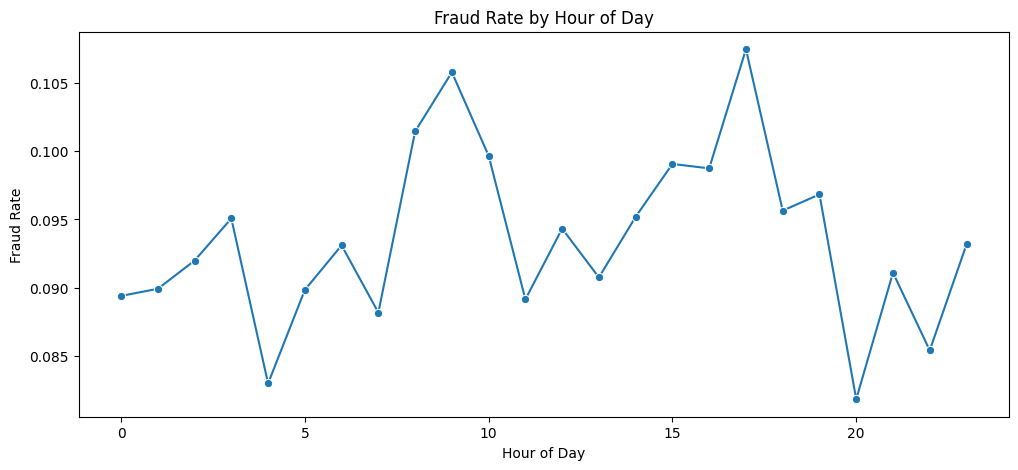

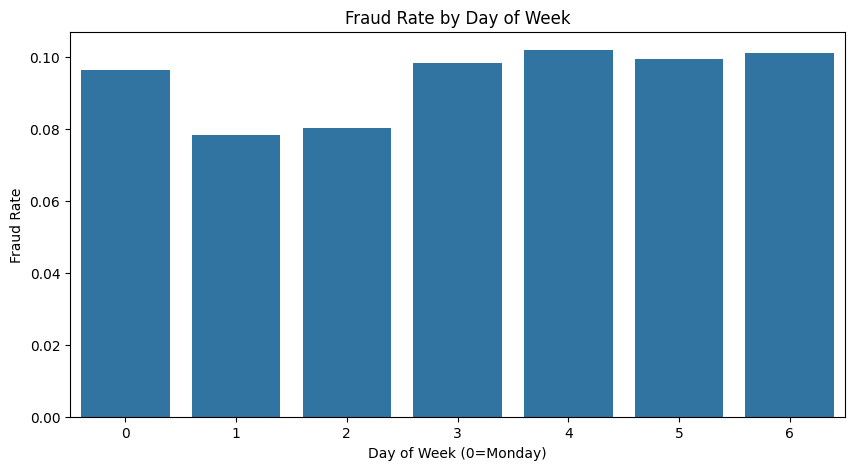

In [32]:
# Fraud rate by hour
hourly_rate = fraud.groupby('hour_of_day')['class'].mean()

plt.figure(figsize=(12,5))
sns.lineplot(x=hourly_rate.index, y=hourly_rate.values, marker='o')
plt.title("Fraud Rate by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Fraud Rate")
plt.show()

# Fraud rate by day of week
daily_rate = fraud.groupby('day_of_week')['class'].mean()

plt.figure(figsize=(10,5))
sns.barplot(x=daily_rate.index, y=daily_rate.values)
plt.title("Fraud Rate by Day of Week")
plt.xlabel("Day of Week (0=Monday)")
plt.ylabel("Fraud Rate")
plt.show()


c:\Users\THINKPAD\Desktop\10_Academy\Week_5\fraud-detection\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


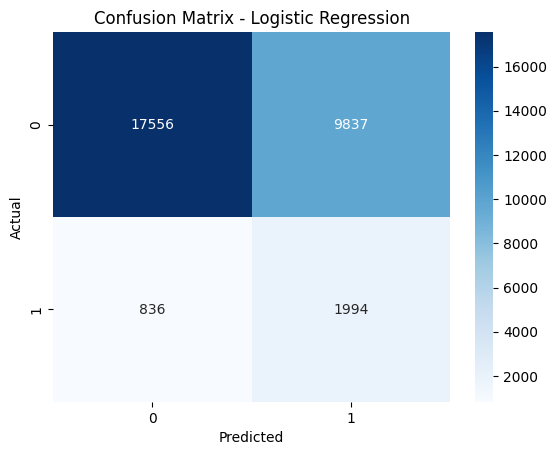

PR-AUC: 0.4969


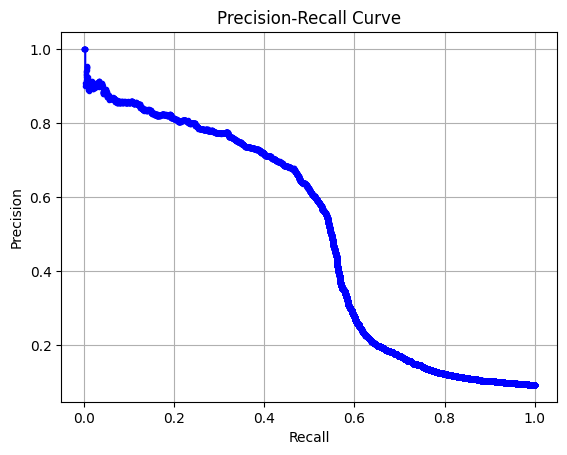

In [34]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, average_precision_score, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

#  Initialize and Train Logistic Regression
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', n_jobs=-1)
log_reg.fit(X_train, y_train)

# Generate Predictions
y_pred = log_reg.predict(X_test)          # predicted class labels
y_proba = log_reg.predict_proba(X_test)[:, 1]  # predicted probabilities for positive class (fraud)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# Precision-Recall AUC
pr_auc = average_precision_score(y_test, y_proba)
print("PR-AUC:", round(pr_auc, 4))

#  Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
plt.plot(recall, precision, marker='.', color='blue')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()


In [35]:
# Save features and target separately as pickle files
X_final.to_pickle("../data/processed/X_final.pkl")
y.to_pickle("../data/processed/y.pkl")

#  save the full dataframe with engineered features too
fraud.to_pickle("../data/processed/Fraud_Data_Processed.pkl")

